In [1]:
# Load necessary CliMA subroutines
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.Mesh.Elements: interpolationmatrix
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()

Plots.GRBackend()

In [2]:
# Initialize CliMA
CLIMA.init()

# Add soil model and other functions
include("soilmodel.jl")
include("thermal_properties.jl")
include("kersten.jl")

kersten (generic function with 1 method)

In [3]:
# Set up domain
# NOTE: this is using 5 vertical elements, each with a 5th degree polynomial, 
# giving an approximate resolution of 5cm
const velems = 0.0:-0.2:-1 # Elements at: [0.0 -0.2 -0.4 -0.6 -0.8 -1.0] (m)
const N = 5 # Order of polynomial function between each element

# Set domain using Stached Brick Topology
topl = StackedBrickTopology(MPI.COMM_WORLD, (0.0:1,0.0:1,velems); 
    periodicity = (true,true,false),
    boundary=((0,0),(0,0),(1,2)))

# Set up grid
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = N)

# Define thermal conductivity
κ_sand = (thermal_properties("Sand",0.35,0.05 ))
κ_clay = (thermal_properties("Clay",0.35,0.05 ))
κ_other = (thermal_properties("Other",0.35,0.05 ))

# Load Soil Model in 'm'
m = SoilModel(
    ρc = (state, aux, t) -> 2.49e6, # aux.z > -0.5 ? 2.49e6 : 2.61e6, 
    κ  = (state, aux, t) -> κ_sand, # aux.z > -0.5 ? κ_sand : κ_clay,
    initialT = (aux, t) -> (273.15 + 2.0),
    surfaceT = (state, aux, t) -> (273.15 + 12.0) + 0.5*10.0 * sinpi(2*(t/(60*60)-8)/24)
)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralNumericalFluxGradient())

# Minimum spatial and temporal steps 
Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2 * 2.42/2.49e6))
dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz


141.9891653167154

In [4]:
# Define time variables
const minute = 60
const hour = 60*minute
const day = 24*hour

# Create plot state function
function plotstate(grid, Q, aux)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    gridg = reshape(grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)*100
    Tg = reshape(aux.data[(1:(N+1)^2:(N+1)^3),2,:],:)
    plot(Tg, gridg, ylabel="depth (cm)", xlabel="T (°K)", yticks=-100:20:0, xlimits=(263.15,303.15), legend=false)
end

plotstate (generic function with 1 method)

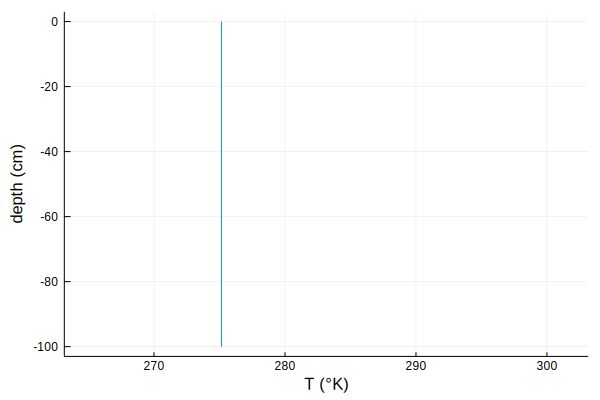

In [5]:
# state variable
Q = init_ode_state(dg, Float64(0))

# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)

# Plot initial state
plotstate(grid, Q, dg.auxstate)


In [6]:
# Solve for one timestep
solve!(Q, lsrk; timeend=dt)

141.9891653167154

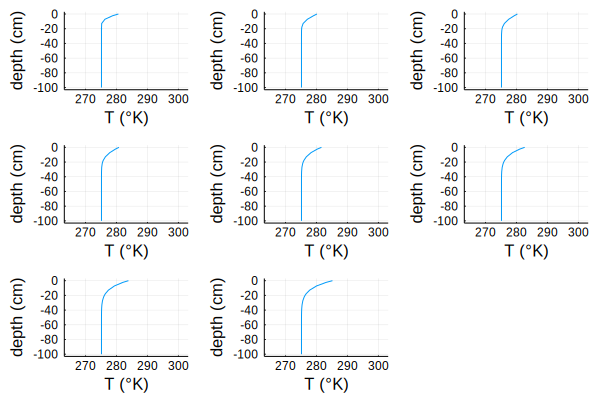

In [7]:
# run for 8 days (hours?) to get to steady state
plots = Any[]
for i = 1:8
    t = solve!(Q, lsrk; timeend=i*hour)
    push!(plots, plotstate(grid, Q, dg.auxstate))
end
plot(plots...)

In [8]:
# a function for performing interpolation on the DG grid
# TODO: use CLIMA interpolation once available
function interpolate(grid, auxstate, Zprofile)
    P = zeros(size(Zprofile))
    nelems = size(grid.vgeo, 3)
    for elem in 1:nelems
        G = grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,elem]
        I = minimum(G) .< Zprofile .<= maximum(G)
        M = interpolationmatrix(G, Zprofile[I])
        P[I] .= M*auxstate.data[(1:(N+1)^2:(N+1)^3),2,elem]
    end
    return P
end

interpolate (generic function with 1 method)

In [9]:
t_plot = 24*4 # How many time steps to plot?
Zprofile = -0.995:0.01:0 # needs to be in sorted order for contour function
Tprofile = zeros(length(Zprofile),t_plot)
hours = 0.5:1:t_plot

for (i,h) in enumerate(hours)
    t = solve!(Q, lsrk; timeend=day+h*hour)
    Tprofile[:,i] = (interpolate(grid, dg.auxstate, Zprofile))
end


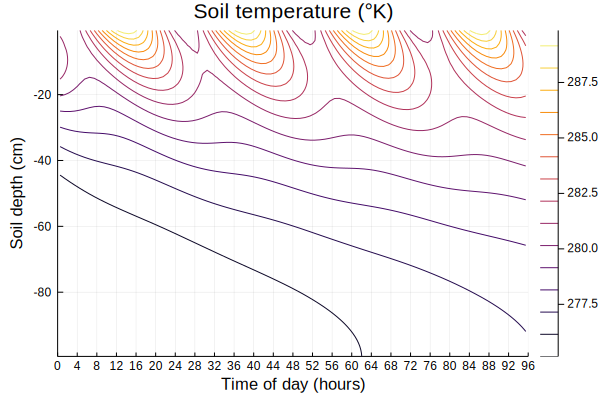

In [10]:
contour(hours, Zprofile.*100, Tprofile, 
    levels=263.15:323.15, xticks=0:4:t_plot, xlimits=(0,t_plot), 
    xlabel="Time of day (hours)", ylabel="Soil depth (cm)", title="Soil temperature (°K)")

In [11]:
# x = a ? b : c

# if a
#     x = b
# else
#     x = c
# end